# COGS 108 - EDA Checkpoint

# Names

- Jonathan Cheung
- Joshua Chuang
- Joyce Hu
- Ester Tsai
- Sam Wong

## Note:

**Old project research question:** Does the sentiment of a US president's Wikipedia page (based on a sentiment score) correlate to their average presidential approval ratings (according to Gallup poll)? (FDR to Biden)

**New project research question:** Which factor, among factors such as director, genre, and sentiment analysis of the plot, has the highest correlation with American film's box office sale?

**Our team chose to pursue a different project research question than our project proposal for the following reasons:**
- The old dataset only has information on 16 presidents (only 16 rows of data after aggregation), so there is not enough data to work with. The new dataset on American films can easily have more than a few thousand rows. 
- The old research question has the issue "no explanation of why the hypothesis was chosen. You should explain the rationale behind the hypothesis." So for our new research question, we will have a stronger rationale behind the hypothesis than the old hypothesis.

### Hypothesis

We hypothesize that American films with more extreme sentiment values have a higher association with higher box office sales than other film characteristics because viewers are more enticed by dramatic film plots. 

<a id='research_question'></a>
# Research Question

Which factor, among factors such as director, genre, and sentiment analysis of the plot, has the highest correlation with American film's box office sale?

# Dataset(s)

- Dataset Name: "American Films.csv"
- Link to the dataset: Web scraped from Wikipedia, so there is no link
- Number of observations: 2521

This dataset was scraped from the Wikipeida page "American Films by Genre" (https://en.wikipedia.org/wiki/Category:American_films_by_genre). It contains the variables 'Film name', 'Genre', 'Plot', 'Directed by', 'Written by', 'Story by', 'Produced by', 'Starring', 'Cinematography', 'Edited by', 'Music by', 'Production company', 'Distributed by', 'Duration (min)', 'Release year', 'Budget (mil dollar)', 'Box office (mil dollar)', 'VADER Sentiment', 'TextBlob Subjectivity', and 'TextBlob Polarity'. It has been filtered to include only the films that have vaild box office values.

# Setup

In [1]:
# Basic libraries
import numpy as np

# Pandas
import pandas as pd
pd.set_option('display.max_columns', None)

# Data visualization
import seaborn as sns
sns.set(font_scale=2, style="white")

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

from scipy.stats import zscore

# set plotting size parameter
plt.rcParams['figure.figsize'] = (12, 5)

# Webscraping
import requests
from bs4 import BeautifulSoup

# Textual and sentiment analysis
import re

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from textblob import TextBlob

import nltk
nltk.download('punkt')
from LeXmo import LeXmo


# Improve resolution
%config InlineBackend.figure_format ='retina'

# Ignore wanrnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from dateutil import parser

[nltk_data] Downloading package punkt to /home/c6wong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/c6wong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Cleaning

## 1) Import Scraped Dataset

In [2]:
df_unfiltered = pd.read_csv('American Films (before cleaning).csv')

# Filter the dataset to include only the rows with a non-null 'Box office'
df = df_unfiltered[df_unfiltered['Box office'].notnull()]

df

,Film name,Genre,Plot,Directed by,Written by,Story by,Produced by,Starring,Cinematography,Edited by,Music by,Production company,Distributed by,Release date,Running time,Budget,Box office
0,The 2nd (film),Action,"While picking up his son at his college dorm, ...",Brian Skiba,Eric Bromberg/ Paul Taegel,NaN,Geoffrey James Clark/ Ryan Phillippe/ Kirk Sha...,Ryan Phillippe/ Casper Van Dien/ Jack Griffo/ ...,Adam Biddle,Scott Conrad,Richard Patrick,NaN,Momentum Pictures/ Voltage Pictures,"September 1, 2020",93 minutes,NaN,"$12,604"
3,12 Rounds (film),Action,A sting operation to capture arms dealer Miles...,Renny Harlin,Daniel Kunka,NaN,Becki Cross Trujillo/ Mark Gordon/ Renny Harli...,John Cena/ Aidan Gillen/ Ashley Scott/ Steve H...,David Boyd,Brian Berdan,Trevor Rabin,NaN,20th Century Fox,NaN,109 minutes,$6.7 million,$17.3 million
6,13 Minutes (2021 film),Action,Four families in the fictional Oklahoma town o...,Lindsay Gossling,Lindsay Gossling,Travis Farncombe,Lindsay Gossling/ Travis Farncombe/ Karen Harn...,Trace Adkins/ Thora Birch/ Peter Facinelli/ An...,Steve Mason,Lisa Grootenboer,Ariel Marx,NaN,Quiver Distribution,"October 29, 2021",108 minutes,NaN,"$67,413"
11,Aces: Iron Eagle III,Action,U.S. Air Force Brigadier General Charles 'Chap...,John Glen,Kevin Alyn Elders,NaN,Ron Samuels,Louis Gossett Jr./ Rachel McLish/ Paul Freeman...,Alec Mills,Bernard Gribble,Harry Manfredini,NaN,Seven Arts (through New Line Cinema)/ New Line...,NaN,98 minutes,$13.5 million,$2.5 million
15,Air Collision,Action,After a major electromagnetic storm cripples c...,Liz Adams,Liz Adams,NaN,David Michael Latt,Reginald VelJohnson/ Jordan Ladd/ Gerald Webb,Stuart Brereton,Rob Pallatina,Chris Ridenhour,NaN,The Asylum,"March 27, 2012",92 minutes,£4 million,£2.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7570,The Young Messiah,Drama,Seven-year-old Jesus is playing in Alexandria ...,Cyrus Nowrasteh,Cyrus Nowrasteh/ Betsy Giffen Nowrasteh,NaN,Michael Barnathan/ Chris Columbus/ Tracy K. Pr...,Adam Greaves-Neal/ Sean Bean/ David Bradley/ L...,Joel Ransom,Geoffrey Rowland,John Debney,NaN,Focus Features,"March 11, 2016",111 minutes,$18.5 million,$7.3 million
7571,The Young Philadelphians,Drama,Newlywed Kate Judson Lawrence (Diane Brewster)...,Vincent Sherman,NaN,NaN,James Gunn,Paul Newman/ Barbara Rush/ Alexis Smith/ Rober...,Harry Stradling,William H. Ziegler,Ernest Gold,NaN,Warner Bros. Pictures,"May 19, 1959",136 minutes,NaN,$2.8 million (est. US/ Canada rentals)
7578,Zabriskie Point (film),Drama,"In a room at a university campus in 1970, whit...",Michelangelo Antonioni,NaN,Michelangelo Antonioni,Carlo Ponti,Mark Frechette/ Daria Halprin/ Rod Taylor,Alfio Contini,Franco Arcalli,John Fahey/ Pink Floyd/ Jerry Garcia/ Grateful...,NaN,Metro-Goldwyn-Mayer,NaN,112 minutes,$7 million,$1 million[Note 1]
7582,Zero Day (2003 film),Drama,"Andre Kriegman (Born July 17, 1982) and Calvin...",Ben Coccio,Ben Coccio/ Christopher Coccio,NaN,Ben Coccio,Andre Keuck/ Cal Robertson,NaN,NaN,NaN,NaN,Avatar Films,"September 3, 2003",92 minutes,"$20,000","$8,466"


## 2) Data Collection

This section contains the code we used to scrape the data from Wikipedia.
### Specify the URLs to scrape

In [3]:
genre_link = {
    'Action': [
        'https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pageuntil=Driving+Force+%281989+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pagefrom=Driving+Force+%281989+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pagefrom=Marksman%2C+The%0AThe+Marksman+%282005+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pagefrom=Spider-Man+3#mw-pages'
    ],
    'Crime': [
        'https://en.wikipedia.org/wiki/Category:American_crime_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=Dial+Red+O#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=Ivy+%28Film%29%0AIvy+%281947+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=One+Stolen+Night+%281929+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=Tenderloin+%28film%29#mw-pages'
    ],
    'War': [
        'https://en.wikipedia.org/wiki/Category:American_war_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_war_films&pagefrom=Retreat%2C+Hell%21#mw-pages'
    ],
    'Romance': [
        'https://en.wikipedia.org/wiki/Category:American_romance_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_romance_films&pagefrom=Sporting+Venus%2C+The%0AThe+Sporting+Venus#mw-pages'
    ],
    'Thriller': [
        'https://en.wikipedia.org/wiki/Category:American_thriller_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_thriller_films&pagefrom=Godsend+%282004+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_thriller_films&pagefrom=Poltergeist+%28film%29%0APoltergeist+%281982+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_thriller_films&pagefrom=Winchester+%28film%29#mw-pages'
    ],
    'Horror': [
        'https://en.wikipedia.org/wiki/Category:American_horror_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_horror_films&pagefrom=Isle+of+the+Dead+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_horror_films&pagefrom=West+of+Hell#mw-pages'
    ],
    'Biographical': [
        'https://en.wikipedia.org/wiki/Category:American_biographical_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_biographical_films&pagefrom=I+Wanna+Dance+with+Somebody+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_biographical_films&pagefrom=Story+of+Alexander+Graham+Bell%0AThe+Story+of+Alexander+Graham+Bell#mw-pages'
    ],
    'Satirical': [
        'https://en.wikipedia.org/wiki/Category:American_satirical_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_satirical_films&pagefrom=Hospital%2C+The%0AThe+Hospital#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_satirical_films&pagefrom=Taintlight%0ATaintlight#mw-pages'
    ],
    'Science Fiction': [
        'https://en.wikipedia.org/wiki/Category:American_science_fiction_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_Western_(genre)_films&pagefrom=Big+Sombrero%2C+The%0AThe+Big+Sombrero+%28film%29#mw-pages'
    ],
    'Monster': [
        'https://en.wikipedia.org/wiki/Category:American_monster_movies',
        'https://en.wikipedia.org/w/index.php?title=Category:American_monster_movies&pagefrom=Fly%2C+The%0AThe+Fly+%281986+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_monster_movies&pagefrom=Nailbiter#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_monster_movies&pagefrom=World+Without+End+%28film%29#mw-pages'
    ],
    'Mystery': [
        'https://en.wikipedia.org/wiki/Category:American_mystery_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=Deceiver+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=House+of+Fear%2C+The%0AThe+House+of+Fear+%281915+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=Murder+She+Baked%0AMurder%2C+She+Baked#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=Seven+Footprints+To+Satan+%28Film%29%0ASeven+Footprints+to+Satan#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=X+Marks+The+Spot%0AX+Marks+the+Spot+%281942+film%29#mw-pages'
    ],
    'Drama': [
        'https://en.wikipedia.org/wiki/Category:American_drama_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Are+These+Our+Children#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Black+Circle+Boys#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Chad+Hanna#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Dancer%27s+Peril%0AThe+Dancer%27s+Peril#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Drunktown%27s+Finest%0ADrunktown%27s+Finest#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Flag+Day+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=God%27s+Little+Acre%0AGod%27s+Little+Acre+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Highway+13+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Invitation+to+Happiness#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Last+Voyage%2C+The%0AThe+Last+Voyage#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Lure+of+the+Swamp#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Million+Dollar+Ransom#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Nomads%0ANomads+%282010+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Pearl+%282020+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Reflections+in+a+Golden+Eye+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Seven+Pounds#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Sporting+Blood+%281940+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Tarantella+%281995+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Treading+Water+%28Film%29%0ATreading+Water+%282001+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Water+Man%2C+The+%28film%29%0AThe+Water+Man+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=World+For+Ransom%0AWorld+for+Ransom#mw-pages'
    ]
}

### Specify the information to include in our dataset

In [4]:
info_list = [
    'Film name', 
    'Genre', 
    'Plot',
    'Directed by',
    'Written by',
    'Story by',
    'Produced by',
    'Starring',
    'Cinematography',
    'Edited by',
    'Music by',
    'Production company',
    'Distributed by',
    'Release date',
    'Running time',
    'Budget',
    'Box office'
]

### Web scrape Wikipedia and construct dataset

In [5]:
def web_scrape_film_wiki_pages(genre_link):

    # Create a blank dataframe and assign column names
    df = pd.DataFrame(columns=info_list)

    # Loop through the genres
    # category_links is a list of URLs for the same genre, but each URL contains around 200 individual films
    for genre, category_links in genre_link.items():

        # Each movie genre has several URLs since not everything can fit on the same page
        # Loop through the URLs in category_links to access all the URLs for each movie genre
        for category_link in category_links:
            req = requests.get(category_link, timeout=50)
            soup = BeautifulSoup(req.content, 'html') # get contents of web page    

            soup.find('div', {'class': 'mw-content-ltr'}).find_all('a', href=True)

            # Each category_link has around 200 individual films' URLs
            # This for loop populates name_links dictionary with the film name as key and Wikipedia page URL as value
            name_links = {}
            for a in soup.find('div', {'class': 'mw-content-ltr'}).find_all('a', href=True):
                film_name = a.text
                link_end = a['href']
                link = 'https://en.wikipedia.org' + link_end
                if 'Categor' not in link: # skip if 'Category' or 'Categorization' is in the link
                    name_links[film_name] = link

            # Loop through the individual films' URLs to extract wanted info
            for film_name, link in name_links.items():
                req = requests.get(link, timeout=50)
                soup = BeautifulSoup(req.content, 'html') # get contents of web page
                tag_contents = soup.select('p, span.mw-headline')

                # Extract the plot (can also be named "Premise" or "Synopsis") if it exists
                start_index_of_plot = -1
                end_index_of_plot = -1
                plot_exists = False

                for i, tag_content in enumerate(tag_contents):
                    tag = tag_content.name
                    content = tag_content.text

                    if (plot_exists) & (tag == 'span'):
                        end_index_of_plot = i
                        break

                    if (content == 'Plot') | (content == 'Premise') | (content == 'Synopsis'):
                        start_index_of_plot = i + 1
                        plot_exists = True

                plot = []
                for content in tag_contents[start_index_of_plot: end_index_of_plot]:
                    par = content.text
                    plot += [par]

                plot = "".join(plot).strip()

                # If plot exists, extract other info as well
                if len(plot) >= 1:

                    film_dict = {'Film name': film_name, 'Genre': genre, 'Plot': plot}

                    # Get other info on the film, if the info table eixsts 
                    try:
                        req = requests.get(link, timeout=50)
                        soup = BeautifulSoup(req.content, 'html')
                        wiki_tables = soup.select('table', {'class': 'infobox vevent'})
                        wiki_table = wiki_tables[0] # get info table

                        # Loop through the tables until we have the info table we want
                        i = 0
                        while 'Directed by' not in wiki_table.text:
                            i += 1
                            wiki_table = wiki_tables[i]

                        # Some minor data cleaning
                        table_html = str(wiki_table).replace('<br/>', '/ ').replace('</li>', '/ ') # replace new line characters with a slash to separate the list of names
                        table_html = re.sub(r"\[\d+\]", "", table_html) # remove brackets (which provide link to references, but are not needed for our project)

                        # Use pd.read_html to create pandas dataframe of the info table
                        df = pd.read_html(table_html) 
                        df = pd.DataFrame(df[0]) # convert list to dataframe
                        df.columns = ['col_name', 'info']
                        df['col_name'] = df['col_name'].replace('/', ' ').replace('companies', 'company').replace('dates', 'date') # fix minor style error
                        df['info'] = df['info'].apply(lambda x: x[:-1] if str(x)[-1] == "/" else x) # fix minor style error

                        info_dict = {k: v for (k, v) in zip(list(df['col_name']), list(df['info'])) if k in info_list}
                        dict_to_append = {**film_dict, **info_dict}

                    # If the info table does not exist, then only append the film name, genre, and plot
                    except:
                        dict_to_append = film_dict

                    # Update the dataframe
                    df = df.append(dict_to_append, ignore_index=True)    
                    
    return df

## 3) Clean and Prepare the Dataset for Analysis
How 'clean' is the data?
- The dataset does require some cleaning. Some current issues with the dataset include:
    - Many string variables contain extra symbols such as reference brackets.
    - 'Running time' is not in a standardized format and is not quantitative. Ideally, it should be an integer representing the number of minutes.
    - 'Budget' is not in a standardized format and is not quantitative. Ideally, it should be a float representing the dollar amount in millions.
    - 'Box office' is not in a standardized format and is not quantitative. Ideally, it should be a float representing the dollar amount in millions.
    - Many columns contain a list of names, which is not ideal for aggregation analysis. We will perform one-hot encoding after choosing which variables to use in our future analysis.

### Clean up text columns

In [6]:
# Remove references from 'Plot' column   
def remove_references(df, col_name):
    return df[col_name].replace(r'\[\d+\]','', regex=True).replace(r'\[\w\]','', regex=True) 
    
df['Plot'] = remove_references(df, 'Plot')
df['Budget'] = remove_references(df, 'Budget')
df['Box office'] = remove_references(df, 'Box office')

### Extract numerical and datetime info from text variables
- 'Running time' &rarr; 'Duration (min)'
- 'Release date' &rarr; 'Release year'
- 'Budget' &rarr; 'Budget (mil dollar)'
- 'Box office' &rarr; 'Box office (mil dollar)'

In [7]:
# 'Duration (min)' extracts the number of minutes from 'Running time'
df['Duration (min)'] = df['Running time'].str.lower().str.extract(r'(?P<duration>[\d]+) min')
# df.drop(columns=['Running time'])


# 'Release year' extracts the year from 'Release date'
df['Release year'] = df['Release date'].str.extract(r'(\d{4})')
# df.drop(columns=['Release date'])


# Function to extract the dollar value in millions from messy string variables
# Averages the values if given a range
def extract_million_dollar(string):
    if (type(string) != str) or ('$' not in string):
        return np.nan
    
    string = string.replace(',', '')
    result = np.nan
    
    if 'equivalent' in string:
        start_idx = string.find('equivalent')+len('equivalent')
        result = float(re.findall(r'(\d+\.?\d*)', string[start_idx:])[0])
        if 'mil' not in string[start_idx:]:
            result = result / 1_000_000
        return result
    
    # Remove all content inside parentheses and brackets
    string = re.sub(r'\([^)]*\)', '', string)
    string = re.sub(r'\[[^]]*\]', '', string)
    nums = re.findall(r'(\d+\.?\d*)', string)
    
    if len(nums) >= 2:
        if ('mil' in string) & ('–' in string):
            nums[0] = float(nums[0])
        else:    
            start_idx = string.find(nums[0])+len(nums[0])
            end_idx = string.find(nums[1])
            if 'mil' in string[start_idx: end_idx]:
                nums[0] = float(nums[0])
            else:
                nums[0] = float(nums[0]) / 1_000_000

        final_num_start_idx = string.find(nums[1])           
        if 'mil' in string[final_num_start_idx:]:
            nums[1] = float(nums[1])
        else:
            nums[1] = float(nums[1]) / 1_000_000

        if ('/' in string) & ('or' not in string):
            result = np.sum(nums[:2])
        else:
            result = np.mean(nums[:2])

    else:
        if 'mil' in string:
            result = float(nums[0])
        else:
            result = float(nums[0]) / 1_000_000
            
    return result


# 'Budget (mil)' extracts the dollar value in millions from 'Budget'
df['Budget (mil dollar)'] = df['Budget'].apply(extract_million_dollar)
# df.drop(columns=['Budget'])

# 'Box office (mil)' extracts the dollar value in millions from 'Box office'
df['Box office (mil dollar)'] = df['Box office'].apply(extract_million_dollar)
# df.drop(columns=['Box office'])

Sanity check the values and assign anything unreasonable to np.nan:

In [8]:
df.describe()

,Budget (mil dollar),Box office (mil dollar)
count,1703.000000,2494.000000
mean,165.489668,31.186075
std,6057.690205,86.331881
min,0.000040,0.000000
25%,1.500000,0.821029
50%,6.500000,2.800000
75%,20.000000,16.800000
max,250000.150000,894.900000


In [9]:
# Check which budget is unreasonably high
df[df['Budget (mil dollar)'] > 500]

,Film name,Genre,Plot,Directed by,Written by,Story by,Produced by,Starring,Cinematography,Edited by,Music by,Production company,Distributed by,Release date,Running time,Budget,Box office,Duration (min),Release year,Budget (mil dollar),Box office (mil dollar)
4307,November (2004 film),Mystery,"On the evening of November 7, photographer Sop...",Greg Harrison,Benjamin Brand/ Greg Harrison,NaN,Jake Abraham/ Danielle Renfrew/ Gary Winick,Courteney Cox,Nancy Schreiber,Greg Harrison,Lew Baldwin,NaN,Sony Pictures Classics,NaN,73 minutes,"$150,000/ $250,000/ $1.5 million","$192,186",73,NaN,250000.15,0.192186


In [10]:
# Manually fix the budget value
idx = df[df['Budget (mil dollar)'] > 500].index
df.at[idx, 'Budget (mil dollar)'] = 1.5

InvalidIndexError: Int64Index([4307], dtype='int64')

### Extract the first person from the list of people in some columns
All of these list-like values contain objects (typically names) that are separated by a slash ("/"). Use `.split('/')` to transform the string into a list.

Working with the assumption that the values are listed in order of importance, we want to simplify a list-like value by extracting the first value in the list. For example, `Starring` for "The 2nd (film)" originally contained "Ryan Phillippe/ Casper Van Dien/ Jack Griffo/ Lexi Simonsen/ William Katt/ Richard Burgi/ William McNamara/ Samaire Armstrong/ Jacob Grodnik/ Randy Charach", but we will extract only the first person in the list, "Ryan Phillippe".

In [ ]:
def extract_first(string):
    if type(string) == str:
        lst = string.split('/')
        return lst[0].strip()
    else:
        return np.nan

cols = ['Directed by', 'Written by', 'Story by',
        'Produced by', 'Starring', 'Cinematography', 'Edited by', 'Music by',
        'Production company', 'Distributed by']

for col in cols:
    df[col] = df[col].apply(extract_first)

### Sentiment Analysis
VADER
- VADER Sentiment lies between [-1,1]
    - -1 defines a negative sentiment and 1 defines a positive sentiment.
    - VADER performs better than TextBlob on identifying negative sentiment.

In [ ]:
VADER_SentimentIntensityAnalyzer = SentimentIntensityAnalyzer()

def get_VADER_sentiment(text):
    return VADER_SentimentIntensityAnalyzer.polarity_scores(text)

df['VADER Sentiment'] = df['Plot'].apply(get_VADER_sentiment)

df['VADER negative'] = df['VADER Sentiment'].apply(lambda x: x['neg'])
df['VADER neutral'] = df['VADER Sentiment'].apply(lambda x: x['neu'])
df['VADER positive'] = df['VADER Sentiment'].apply(lambda x: x['pos'])
df['VADER compound'] = df['VADER Sentiment'].apply(lambda x: x['compound'])
df['VADER compound (absolute value)'] = df['VADER Sentiment'].apply(lambda x: abs(x['compound']))

TextBlob
- TextBlob Polarity lies between [-1,1]
    - -1 defines a negative sentiment and 1 defines a positive sentiment. 
    - Negation words reverse the polarity. When any negation is added with any sentence it simply multiplies -0.5 to the polarity score of the word. 
- TextBlob Subjectivity lies between [0,1]. 
    - Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.

In [ ]:
def get_TextBlob_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_TextBlob_polarity(text):
    return TextBlob(text).sentiment.polarity

df['TextBlob subjectivity'] = df['Plot'].apply(get_TextBlob_subjectivity)
df['TextBlob polarity'] = df['Plot'].apply(get_TextBlob_polarity)

## 4) Resulting Dataset

In [ ]:
# Filter out the rows without a valid value for 'Box office (mil dollar)'
df = df[df['Box office (mil dollar)'].notnull()]

df.to_csv('American Films.csv', index=False)

In [ ]:
df = pd.read_csv('American Films.csv')

df

Note: For all the categorical values we plan to analyze, perform statistical tests on, or create machine learning models with, we may need to perform one-hot encoding to create quantitative values. But we will perform that step after EDA as needed.

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

[JCheung] Quantitative: duration, budget, release year (not really quantitative but can go here)
How many movies are released each year?


Import American Films dataset into "df."

In [ ]:
df = pd.read_csv('American Films.csv')
df.head()

Assign "quant" to be the columns that Quantitative EDA will be performed on. This includes the duration, budget, release year, and box office columns.

In [ ]:
quant = df[['Duration (min)', 'Release year', 'Budget (mil dollar)', 'Box office (mil dollar)']]

Displaying descriptive statistics on the dataset.

In [ ]:
quant.describe()

Exploring the distributions of the data columns.

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(10,18))

sns.histplot(quant['Duration (min)'], ax=axs[0]).set(title='Distribution of Movie Durations (mins)')
sns.histplot(quant['Release year'], ax=axs[1]).set(title='Distribution of Movie Release Year')
sns.histplot(quant['Budget (mil dollar)'], ax=axs[2]).set(title='Distribution of Movie Budget (mil)')
sns.histplot(quant['Box office (mil dollar)'], ax=axs[3]).set(title='Distribution of Box Office (mil)')

plt.tight_layout()
plt.show()

As seen in the histograms, all columns except the release year column contain outliers. Specifically for budget and box office distributions, they both look similar and are both heavily skewed to the right.

Removing ouliers shows a clearer distribution.

In [ ]:
#Budget distribution with outliers removed
sns.histplot(quant[quant['Budget (mil dollar)'] <= 100]['Budget (mil dollar)']).set(title='Distribution of Movie Budget (mil)')


By only plotting the distribution of movies with budgets less than or equal to 100 million dollars, we can see that most movies have budgets under 20 million dollars. This also realistically makes sense given that a higher budget would neccessitate a greater box office to return a profit.

In [ ]:
#Box Office distribution with outliers removed
sns.histplot(quant[quant['Box office (mil dollar)'] <= 100]['Box office (mil dollar)']).set(title='Distribution of Box Office (mil)')


Applying the same threshold to the box office data yields a distribution that looks similar to the budget distribution. This could suggest a relationship between movie budget and its respective box office amount.

In [ ]:
#Scatterplot comparing Budget and Box office (in millions)
sns.lmplot(x='Budget (mil dollar)', y='Box office (mil dollar)',data=quant, fit_reg=False, height=6,aspect=2, scatter_kws={'color':'red'})


In [ ]:
#Scatterplot with regression line
sns.lmplot(x='Budget (mil dollar)', y='Box office (mil dollar)',data=quant, fit_reg=True, height=6,aspect=1.7,line_kws={'color':'red'},scatter_kws={'color':'red'})


Plotting the Budget versus the Box office values of all the movies shows a rough positive correlation between budget and box office. However, this cannot imply causation given that there is lots of noise and outliers. The positive correlation line plotted is most likely due to the clustering of a large majority of the dataset under $100 million in both budget and box office.

So while there is technically a positive correlation between budget and box office, no correlation relationship can be deduced from the given dataset.

Furthermore, restricting the plot to data that falls below $100 million does not improve the regression line nor further imply a relationship given that outliers exist at an even higher frequency as the budget and box office decreases.

Another interesting question to investigate is whether more recent movies are more popular. A way that this can be explored is by plotting the Box Office amount to the Release year of the movie.

In [ ]:
#Release year versus Box Office
sns.lmplot(x='Release year', y='Box office (mil dollar)',data=quant, fit_reg=False, height=6,aspect=2)


When plotted as a scatterplot, we can see that the highest box office values exist solely in the 2000s or later which can imply the increased popularity of recent movies. This also makes sense given the greater interconnectivety of modern society within the past 20 years.

# How many genres are there in our dataset?

In [11]:
df = pd.read_csv("American Films.csv")


In [12]:
genres = df['Genre'].value_counts()

<AxesSubplot:>

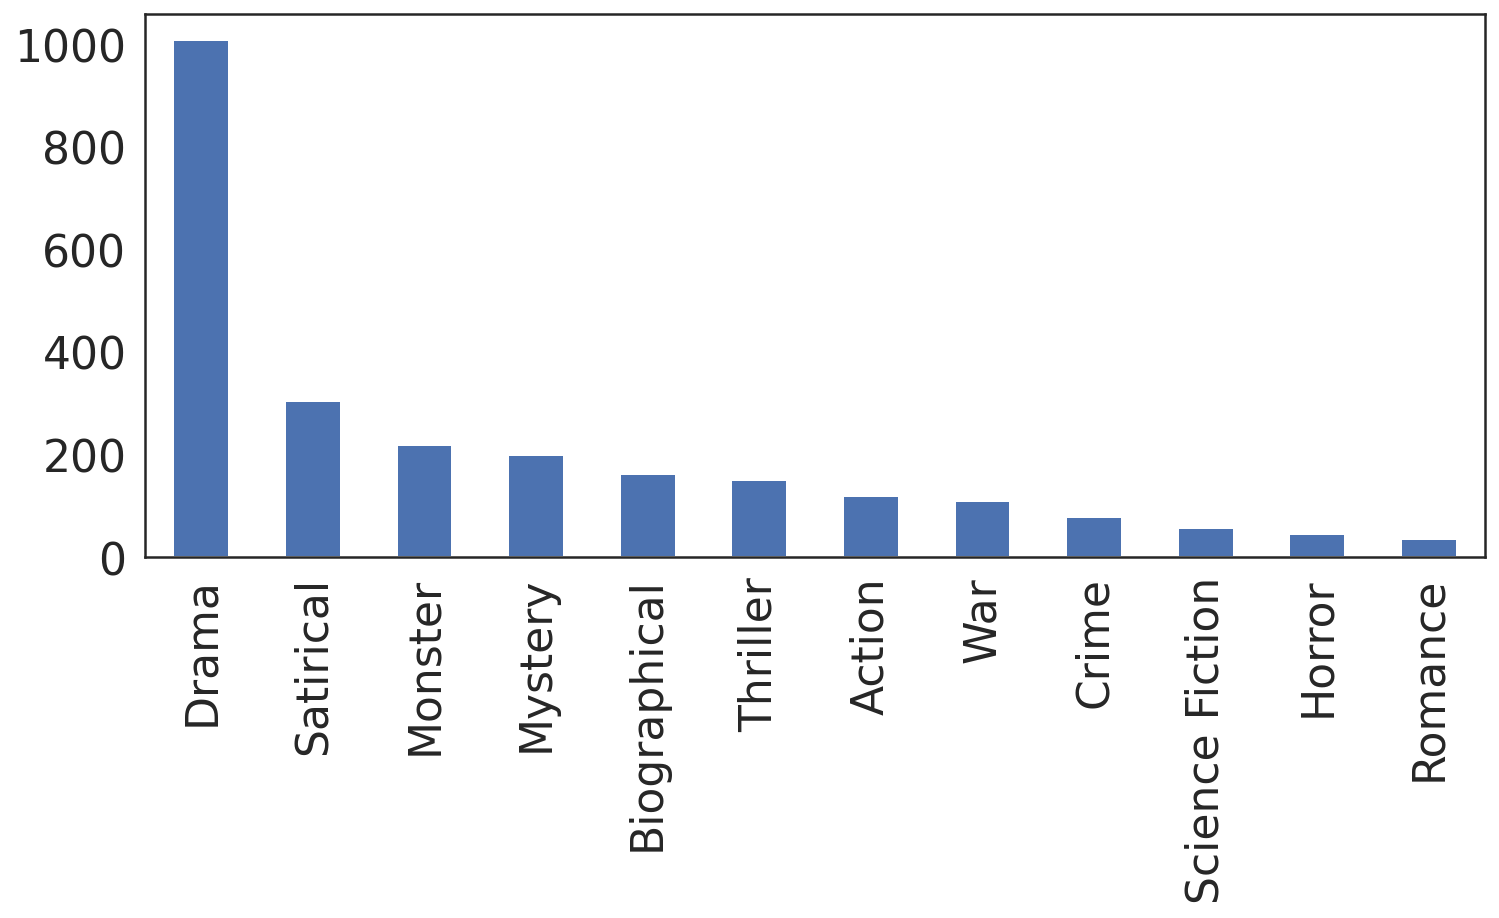

In [13]:
genres.plot.bar()

# Which genres perform much better in box office? 
In order to answer this question, we will need to calculate the mean box office for each genre, and z-transform the mean box office.

In [14]:
# Prepare a dataframe 
df2 = df[['Genre','Box office (mil dollar)']]
total_mean = df2['Box office (mil dollar)'].mean()
genres = ['Drama','Satirical','Monster','Monster','Mystery','Biographical','Thriller','Action','War','Crime','Science Fiction','Horror','Romance']
new = pd.DataFrame(columns=['Genres','Box Office'])



#A function that takes a list of box office stats and calculate the z score
def z_score_table(genre):
    
    new = pd.DataFrame(columns=['Genres','Mean Box Office'])
    for items in genre:

        New_Genre = df2[df2['Genre'] == items]
        New_Genre_mean = New_Genre['Box office (mil dollar)'].mean()
        #print(New_Genre_mean)
        dict = {'Genres': items, 'Mean Box Office': [New_Genre_mean]}
        row = pd.DataFrame(dict)
        new = pd.concat([new,row])


    return new

df3 = z_score_table(genres)
df3['Box Office Z-Score'] = zscore(df3['Mean Box Office'])
df3

,Genres,Mean Box Office,Box Office Z-Score
0,Drama,10.459604,-1.088139
0,Satirical,43.176346,0.025463
0,Monster,84.384734,1.428101
0,Monster,84.384734,1.428101
0,Mystery,37.168484,-0.179031
0,Biographical,25.900356,-0.562572
0,Thriller,22.922987,-0.663914
0,Action,98.458297,1.907132
0,War,12.975196,-1.002514
0,Crime,24.665517,-0.604603


We'll compare z-scores using a bar chart for easier comparison in vlaues.

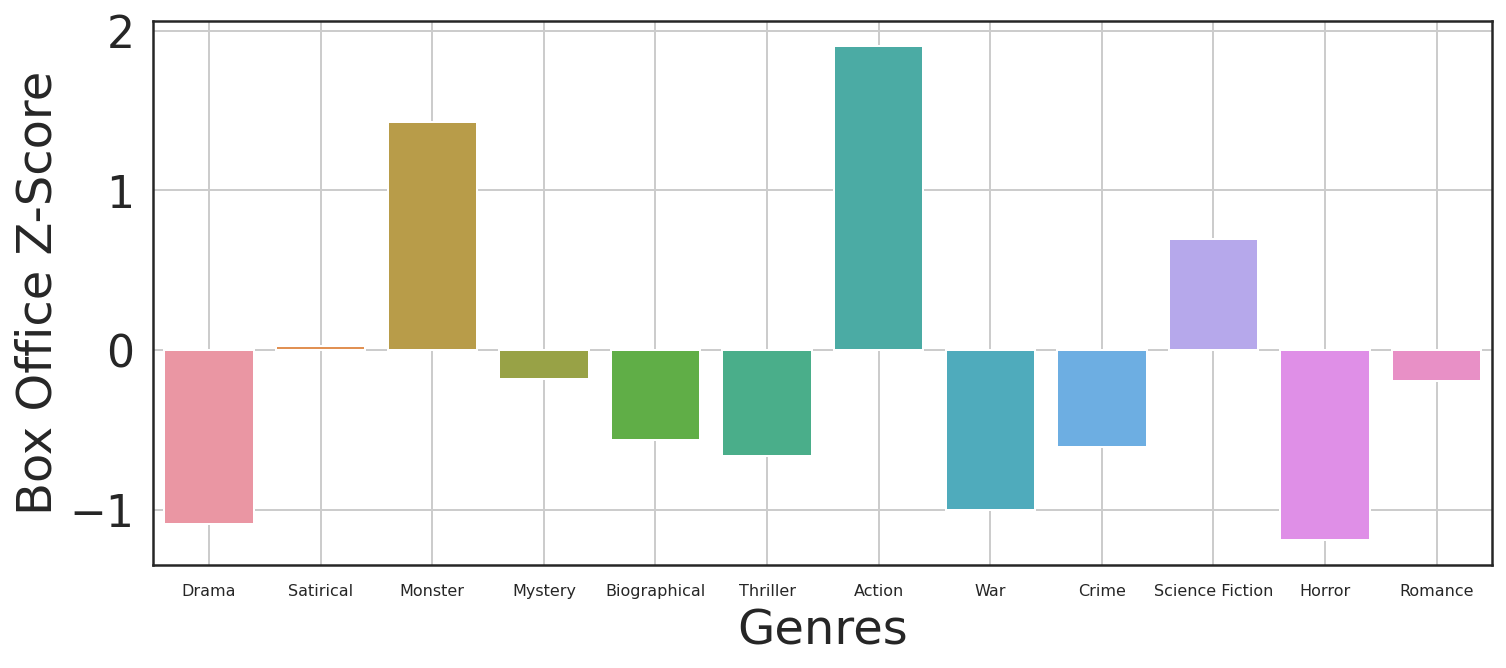

In [15]:
# plotting the z score
ax = sns.barplot(data=df3, x="Genres", y="Box Office Z-Score")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
plt.grid()
plt.show()

We can see that Action movies does perform better than other genres. The second runner up are Monster movies and science fiction. While Drama and Horror films does the poorest in box office. 

# What are the trends for profits across the Years with different movie genres?

We first extract the Genre, Date and the Box Office Column

In [16]:
df4 = df.iloc[:,[1,13,20]]
df4

,Genre,Release date,Box office (mil dollar)
0,Action,"September 1, 2020",0.012604
1,Action,NaN,17.300000
2,Action,"October 29, 2021",0.067413
3,Action,NaN,2.500000
4,Action,"August 30, 1985",10.499694
...,...,...,...
2489,Drama,"March 11, 2016",7.300000
2490,Drama,"May 19, 1959",2.800000
2491,Drama,NaN,1.000000
2492,Drama,"September 3, 2003",0.008466


We want to analyse the year of the release dates. So let's clean up the data.
First, Drop any blank rows

In [17]:
df4 = df4.dropna()
df4

,Genre,Release date,Box office (mil dollar)
0,Action,"September 1, 2020",0.012604
2,Action,"October 29, 2021",0.067413
4,Action,"August 30, 1985",10.499694
5,Action,"May 1, 1987",4.000000
6,Action,"February 24, 1989)",1.556606
...,...,...,...
2486,Drama,"October 10, 2014",0.894964
2487,Drama,"December 25, 2003",9.638389
2489,Drama,"March 11, 2016",7.300000
2490,Drama,"May 19, 1959",2.800000


In [18]:
df4['Release date'].unique()

array(['September\xa01,\xa02020', 'October\xa029,\xa02021',
       'August\xa030,\xa01985', ..., 'March\xa011,\xa02016',
       'May\xa019,\xa01959', 'September\xa03,\xa02003'], dtype=object)

 Let's try and extract the year from the date string

In [19]:
def get_year(date_string):
    try:
        res = parser.parse(date_string, fuzzy=True).year
        return res
    except:
        return np.nan

In [20]:
df4['Release date'] = df4['Release date'].apply(get_year)
df4 = df4.dropna()
df4

,Genre,Release date,Box office (mil dollar)
0,Action,2020.0,0.012604
2,Action,2021.0,0.067413
4,Action,1985.0,10.499694
5,Action,1987.0,4.000000
6,Action,2022.0,1.556606
...,...,...,...
2486,Drama,2014.0,0.894964
2487,Drama,2003.0,9.638389
2489,Drama,2016.0,7.300000
2490,Drama,1959.0,2.800000


Remove the trailing zeros by converting it into an int

In [21]:
df4['Release date'] = df4['Release date'].astype(int)
df4

,Genre,Release date,Box office (mil dollar)
0,Action,2020,0.012604
2,Action,2021,0.067413
4,Action,1985,10.499694
5,Action,1987,4.000000
6,Action,2022,1.556606
...,...,...,...
2486,Drama,2014,0.894964
2487,Drama,2003,9.638389
2489,Drama,2016,7.300000
2490,Drama,1959,2.800000


Again, we will calculate the mean box office of all teh genres in the df. However, this time we will calculate the mean based on the year. Combine all means into a new dataframe.

In [22]:
def calculate_mean(Genre, new):
    # Select all that are from year 2020
    df_action = df4[df4['Genre'] == Genre]
    year_list = df_action['Release date'].unique()

    for years in year_list:
        df_action_year = df_action[df_action['Release date'] == years]
        genre_year_mean = df_action_year['Box office (mil dollar)'].mean()
        dict_2 = {'Genres': Genre, 'Mean Box Office': [genre_year_mean],'year': years}
        #Create new dataframe
        row = pd.DataFrame(dict_2)
        new = pd.concat([new,row])

    return new

In [23]:
genre_list = df4['Genre'].unique()
new = pd.DataFrame(columns=['Genres','Mean Box Office','year'])
for genre in genre_list:
    new = calculate_mean(genre,new) 
new

,Genres,Mean Box Office,year
0,Action,0.176207,2020
0,Action,0.059791,2021
0,Action,96.474923,1985
0,Action,5.367081,1987
0,Action,0.539422,2022
...,...,...,...
0,Drama,1.615000,1968
0,Drama,24.987600,1995
0,Drama,0.676559,1935
0,Drama,0.938000,1926


Below we'll plot the box office trends based on different genres in several time periods. Namely 1980-1989, 1990-1999, 2000-2009, 2010-2020. A line plot allows us to analyse trends easily

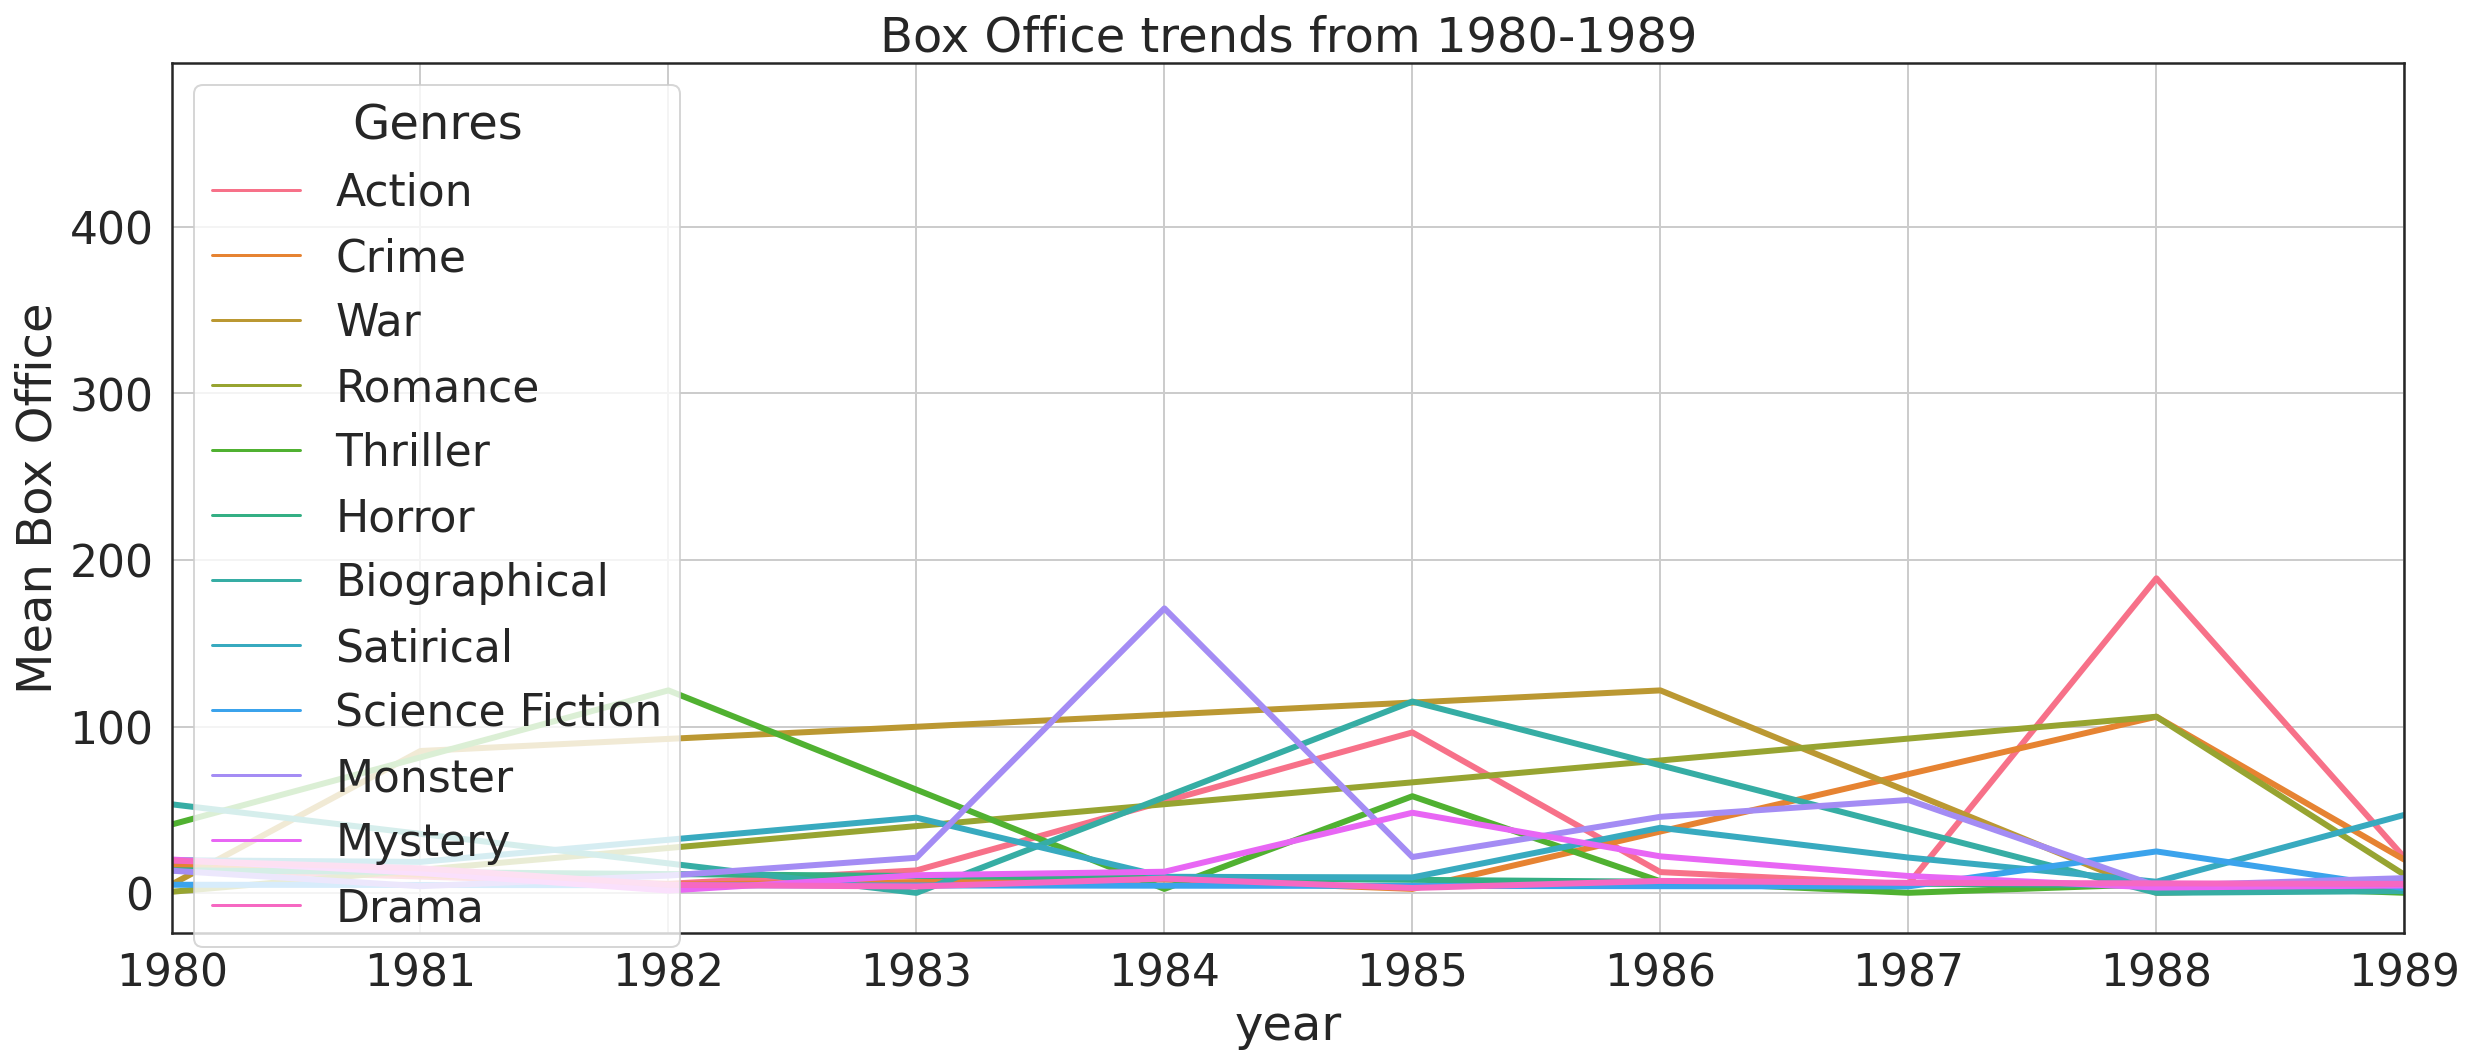

In [24]:
f4, ax = plt.subplots(figsize =(20, 8))
plt.xlim(1980, 1989)
f4 = sns.lineplot(data=new, x="year", y="Mean Box Office", hue='Genres',legend='brief',linewidth=3).set(title="Box Office trends from 1980-1989")
plt.grid()

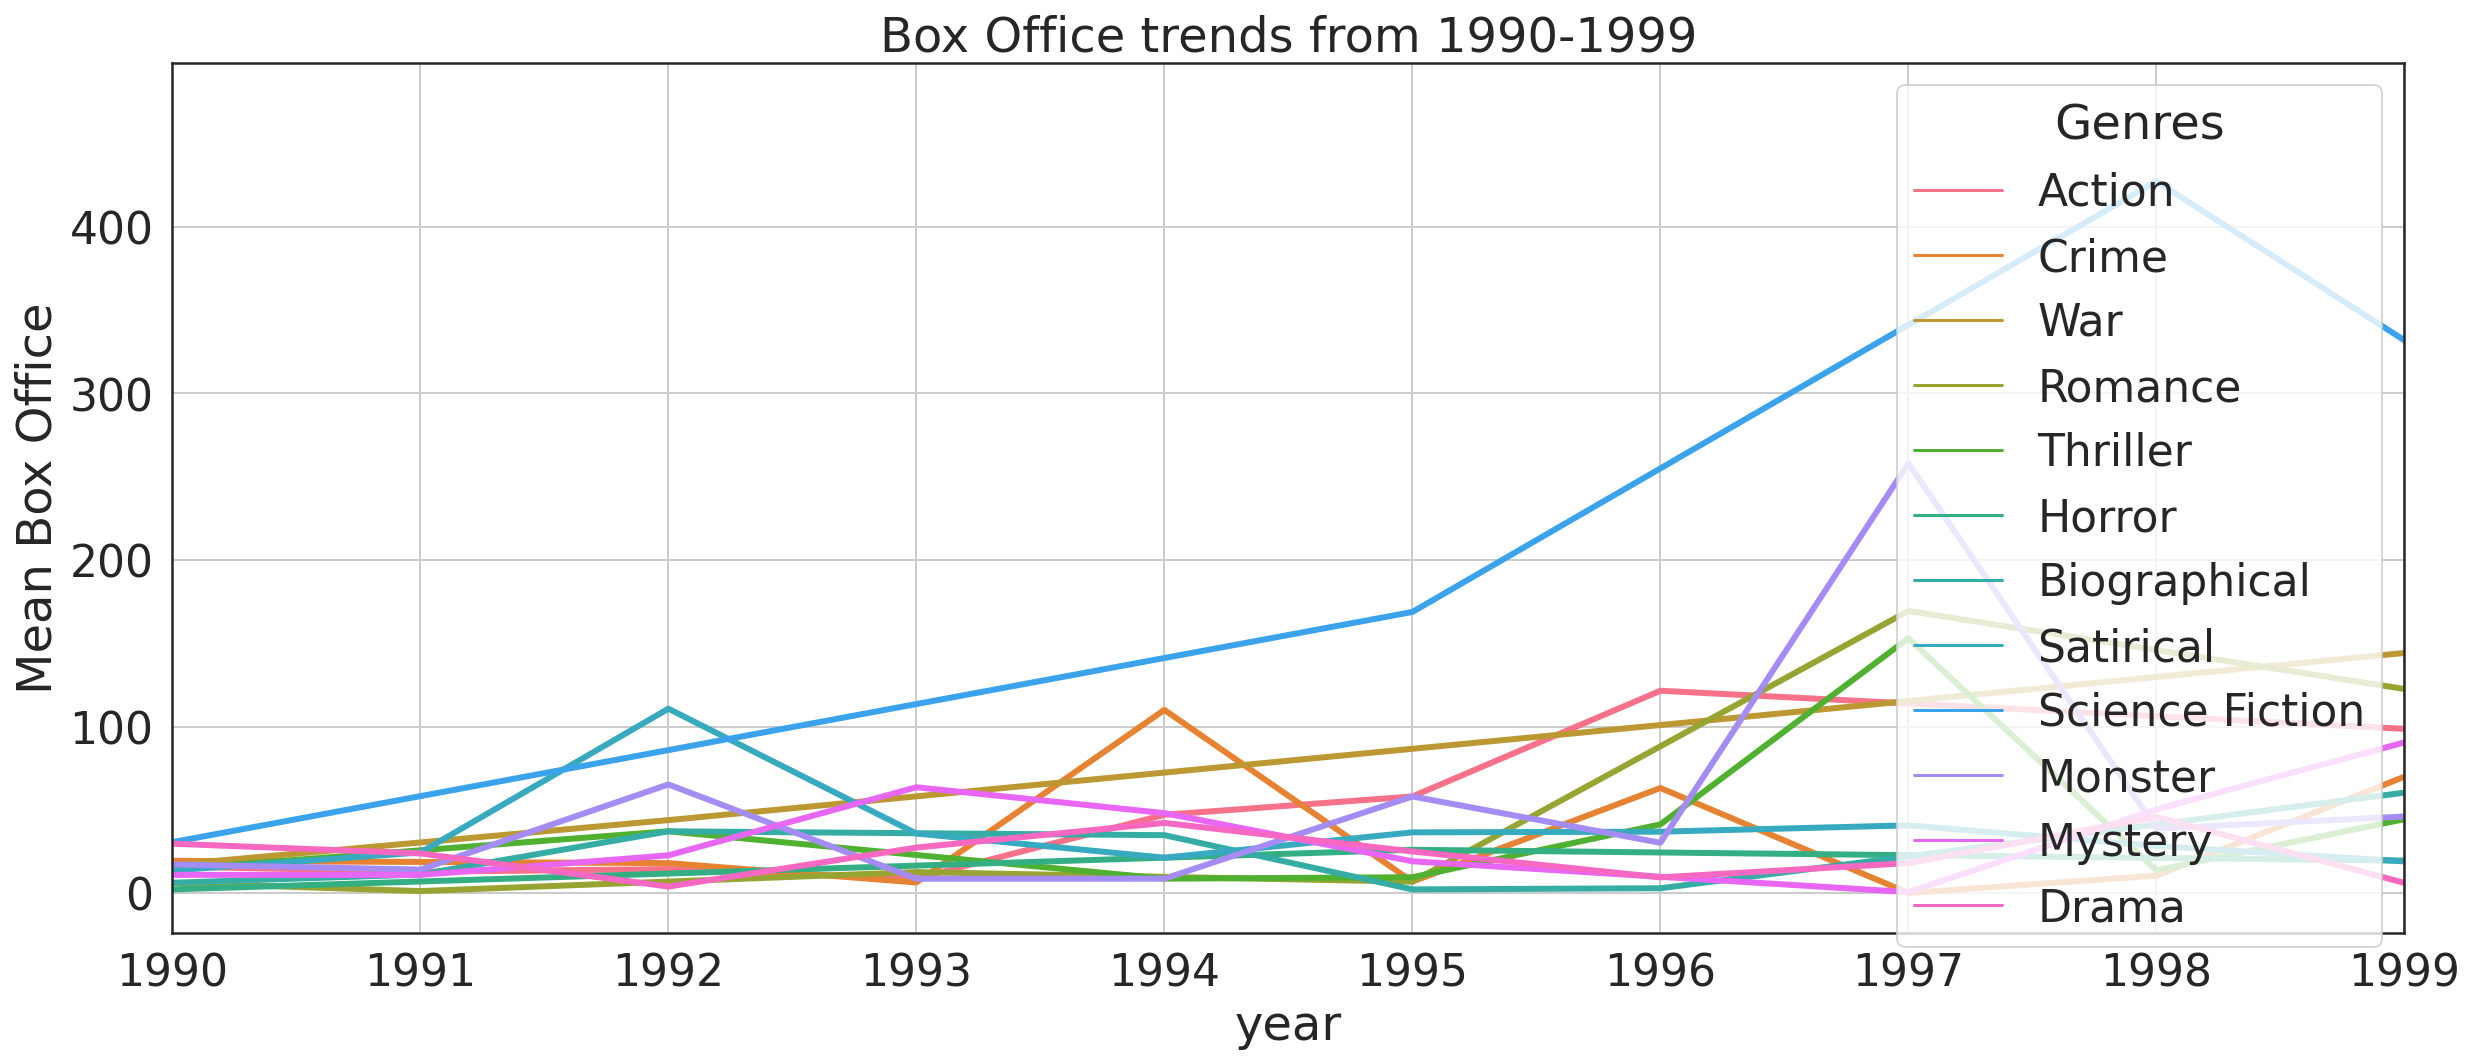

In [25]:
f3, ax = plt.subplots(figsize =(20, 8))
plt.xlim(1990, 1999)
f3 = sns.lineplot(data=new, x="year", y="Mean Box Office", hue='Genres',legend='brief', linewidth=3).set(title="Box Office trends from 1990-1999")
plt.grid()

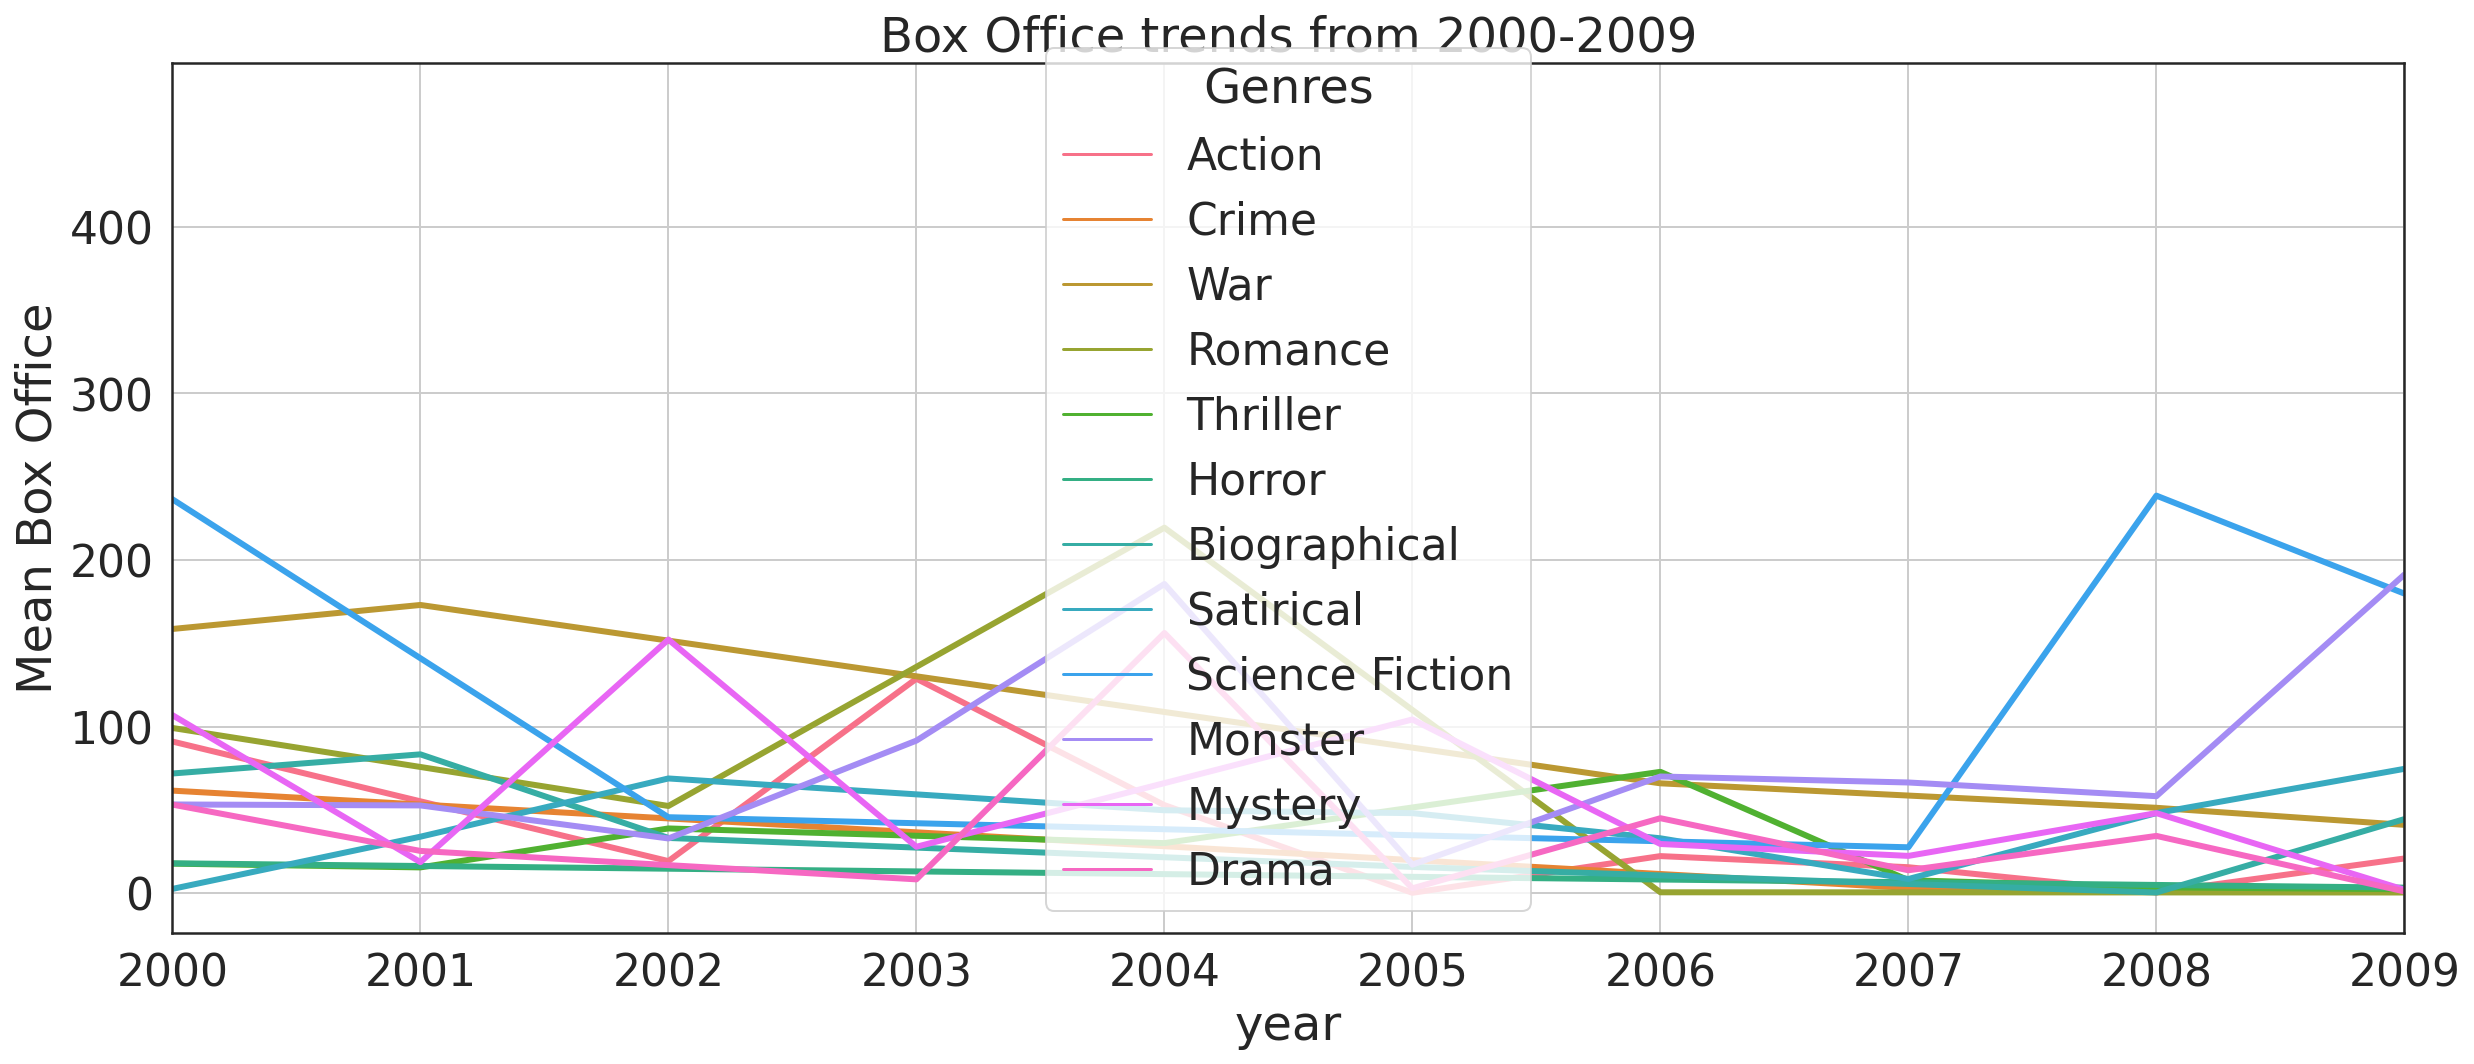

In [26]:
f2, ax = plt.subplots(figsize =(20, 8))
plt.xlim(2000, 2009)
f2 = sns.lineplot(data=new, x="year", y="Mean Box Office", hue='Genres',legend='brief',linewidth=3).set(title="Box Office trends from 2000-2009")
plt.grid()

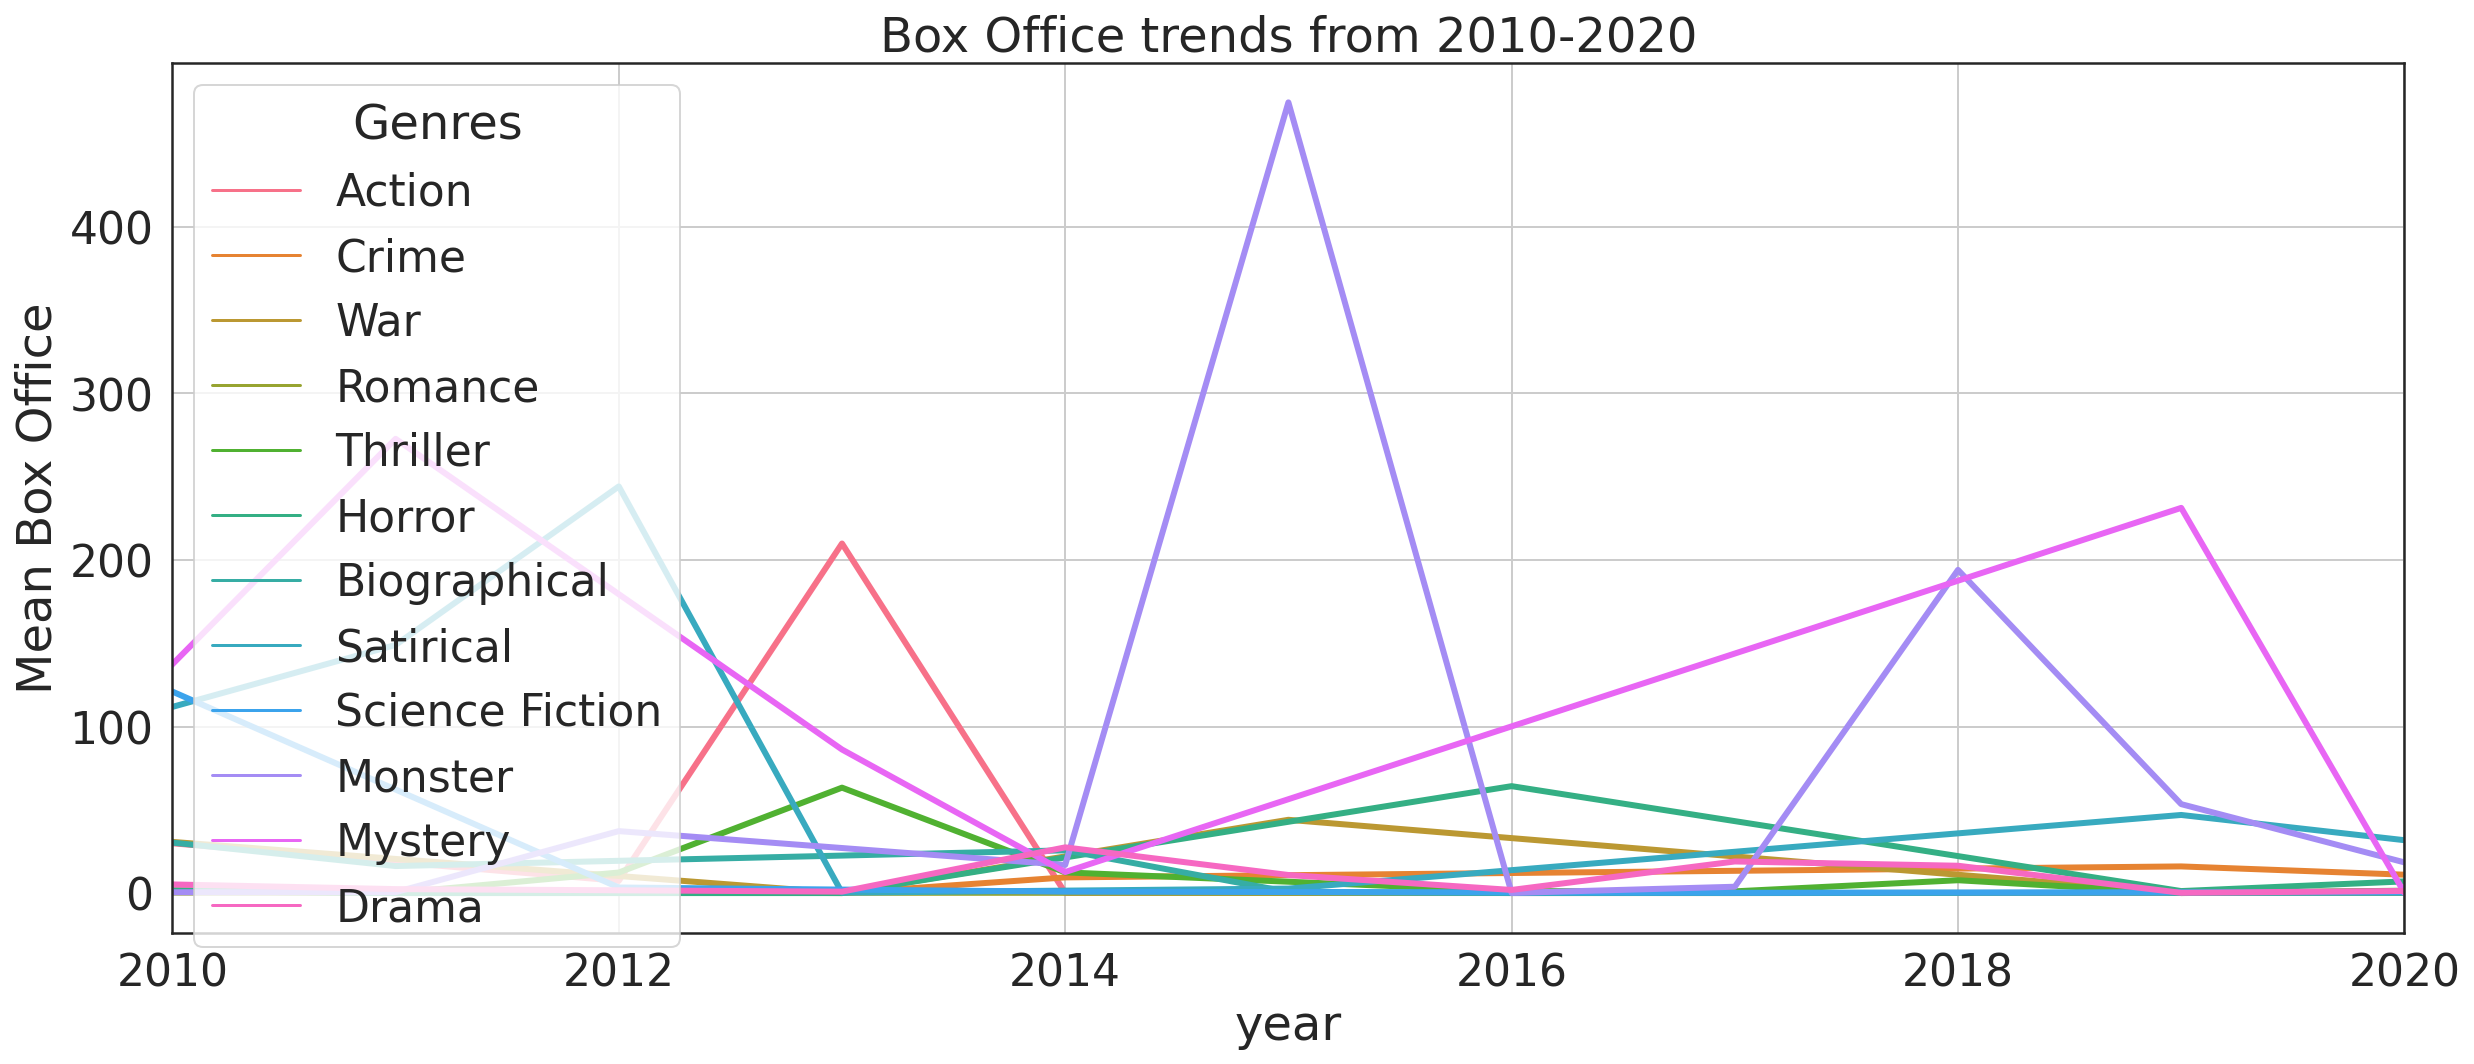

In [27]:
f1, ax = plt.subplots(figsize =(20, 8))
plt.xlim(2010, 2020)
f1 = sns.lineplot(data=new, x="year", y="Mean Box Office", hue='Genres',legend='brief',linewidth = 3).set(title="Box Office trends from 2010-2020")
plt.grid()

As we can see, Science Fiction films have high box office in the 1990s and 2000s but box office dropped in the 2010s. And Monsters film were on the rise since 1990s and peaked at 2010s. In the 2010s, Mystery films increased in box office compared to other eras.

# How does the movie plot correlate with box office?

In [28]:
# get attributes of each plot
char_count = []
word_count = []
box_office = []
punct_count = []
upper_count = []
sent_count = []

for i in range(len(df)):
    text = df.loc[i]['Plot']
    # number of characters
    char_count.append(len(text))
    # number of words
    word_count.append(len(text.split(' ')))
    # box office
    box_office.append(df.loc[i]['Box office (mil dollar)'])
    # number of punctuation
    punct_count.append(len([c for c in text if c in string.punctuation]))
    # number of sentences
    sent_count.append(len(re.findall(r'[.!?]', text)))
    # number of uppercase
    upper_count.append(len(re.findall(r'[A-Z]', text)))

NameError: name 'string' is not defined

In [ ]:
# plot char counts vs other counts
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax1 = sns.scatterplot(x=char_count, y=word_count, ax=ax[0][0])
ax1.set(xlabel='Number of Characters', ylabel='Number of Words')
ax2 = sns.scatterplot(x=char_count, y=punct_count, ax=ax[1][0])
ax2.set(xlabel='Number of Characters', ylabel='Number of Punctuation')
ax3 = sns.scatterplot(x=char_count, y=sent_count, ax=ax[0][1])
ax3.set(xlabel='Number of Characters', ylabel='Number of Sentences')
ax4 = sns.scatterplot(x=punct_count, y=upper_count, ax=ax[1][1])
ax4.set(xlabel='Number of Characters', ylabel='Number of Upper Case Letters')

The attributes of the plot, like the number of characters, words, punctuation, sentences, and uppercase letters are pretty linear to one another. This makes sense as the longer the plot text is, these attributes will appear more often.

In [ ]:
# plot the distribution of count values
fig, ax = plt.subplots(2, 2, figsize=(18, 6))
sns.histplot(char_count, ax=ax[0][0])
sns.histplot(word_count, ax=ax[0][1])
sns.histplot(punct_count, ax=ax[1][0])
sns.histplot(sent_count, ax=ax[1][1])


Being pretty linear to one another, it is not surprising that the distributions of these counts look very similar.

In [ ]:
# plot count values vs box office
fig, ax = plt.subplots(3, 2, figsize=(18, 18))
ax1 = sns.scatterplot(x=char_count, y=box_office, ax=ax[0][0])
ax1.set(xlabel='Number of Characters', ylabel='Box Office (Millions of Dollars)')
ax2 = sns.scatterplot(x=word_count, y=box_office, ax=ax[0][1])
ax2.set(xlabel='Number of Words', ylabel='Box Office (Millions of Dollars)')
ax3 = sns.scatterplot(x=punct_count, y=box_office, ax=ax[1][0])
ax3.set(xlabel='Number of Punctuation', ylabel='Box Office (Millions of Dollars)')
ax4 = sns.scatterplot(x=sent_count, y=box_office, ax=ax[1][1])
ax4.set(xlabel='Number of Sentences', ylabel='Box Office (Millions of Dollars)')
ax5 = sns.scatterplot(x=upper_count, y=box_office, ax=ax[2][0])
ax5.set(xlabel='Number of Upper Case Words', ylabel='Box Office (Millions of Dollars)')
fig.delaxes(ax[2][1])

In [ ]:
# plot count values vs log of box office
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax1 = sns.scatterplot(x=sent_count, y=np.log(box_office), ax=ax[0])
ax1.set(xlabel='Number of Characters', ylabel='Log of Box Office (Millions of Dollars)')
ax2 = sns.scatterplot(x=upper_count, y=np.log(box_office), ax=ax[1])
ax2.set(xlabel='Number of Uppercase', ylabel='Log of Box Office (Millions of Dollars)')

In [ ]:
# gets the counts of each part of speech
def get_pos_count(text):
    tokens=nltk.word_tokenize(text)
    word_pos = []
    pos_count = defaultdict(int)
    for word, tag in nltk.pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
            pos_count['n'] += 1
        elif tag.startswith('VB'):
            pos = 'v'
            pos_count['v'] += 1
        elif tag.startswith('JJ'):
            pos = 'adj'
            pos_count['adj'] += 1
        elif tag.startswith('RB'):
            pos = 'adv'
            pos_count['adv'] += 1
        else:
            pos = 'a'
            pos_count['a'] += 1
        word_pos.append((word, pos))
    return word_pos, pos_count

In [ ]:
# get part of speech of each plot
pos_count = []
noun_count = []
verb_count = []
adj_count = []
adv_count = []

for i in range(len(df)):
    text = df.iloc[i]['Plot']
    word_pos, pos = get_pos_count(text)
    pos_count.append(pos)
for i in pos_count:
    noun_count.append(i['n'])
    verb_count.append(i['v'])
    adj_count.append(i['adj'])
    adv_count.append(i['adv'])

In [ ]:
# plot counts of part of speech vs box office
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax1 = sns.scatterplot(x=noun_count, y=box_office, ax=ax[0][0])
ax1.set(xlabel='Number of Nouns', ylabel='Box Office (Millions of Dollars)')
ax2 = sns.scatterplot(x=verb_count, y=box_office, ax=ax[0][1])
ax2.set(xlabel='Number of Verbs', ylabel='Box Office (Millions of Dollars)')
ax3 = sns.scatterplot(x=adj_count, y=box_office, ax=ax[1][0])
ax3.set(xlabel='Number of Adjectives', ylabel='Box Office (Millions of Dollars)')
ax4 = sns.scatterplot(x=sent_count, y=box_office, ax=ax[1][1])
ax4.set(xlabel='Number of Adverbs', ylabel='Box Office (Millions of Dollars)')

The plots of the counts of each part of speech vs box office also look similar to our counts vs box office plots from before. This makes sense as the counts of each part of speech will also be linearly correlated with the size of the plot text with the same reasoning the counts of each attribute of the text was linearly correlated.